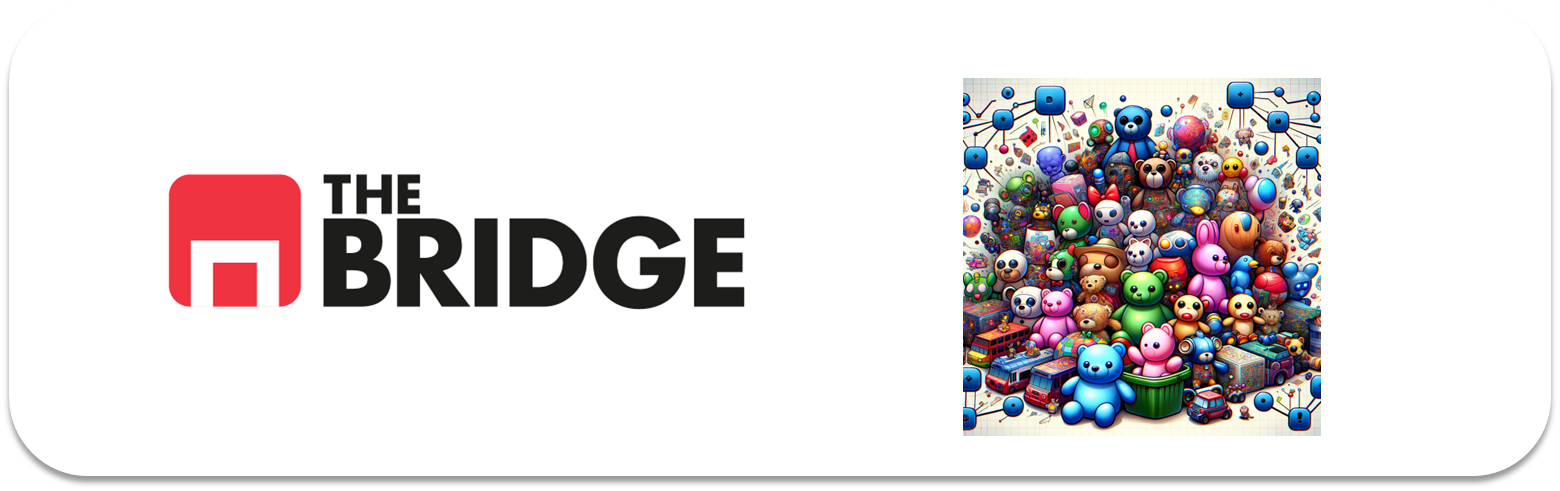

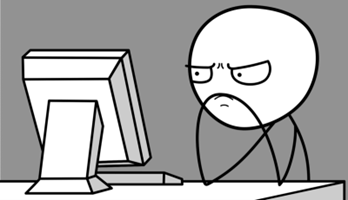

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descargar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from bootcampviztools import plot_combined_graphs, plot_grouped_histograms, plot_combined_graphs

import itertools #función de python que genera todas las combinaciones de features

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.metrics import adjusted_rand_score, confusion_matrix

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [253]:
path_to_file = "./data/empowering_drinks.csv"
data = pd.read_csv(path_to_file, sep = "|")

In [254]:
data

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276
...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783
149,0.332758,-0.389355,-1.344582,0.280575,2.224236
150,0.209232,0.012732,-1.354622,0.296498,1.834923
151,1.395086,1.365208,-1.274305,-0.595160,1.791666


Hay valores negativos en algunos de los componentes. Veamos cuántos en cada columna:

In [255]:
# Contar valores negativos en cada columna
valores_negativos = (data < 0).sum()
print(valores_negativos)

Azúcares                 72
Vitamínas del grupo B    78
Cafeína                  66
Ácido Cítrico            84
Taurina                  85
dtype: int64


Tantos negativos no parecen fallos de transcripción, hago un describe a ver cómo se distribuyen las métricas.

In [256]:
data.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


Tengo un dataset con 5 columnas o features y 153 filas (no son muchas) y además no hay nulos y todos son decimales. Pero todos esos negativos y ese rango de entre -3 y 3; -2 y 2... en los parámetros del describe me da que los datos han sido estandarizados con Standard Scaler (Min Max no puede ser precisamente por los negativos).

In [258]:
# Verificar si los datos han sido estandarizados
print("Media:\n", data.mean())
print("Desviación estándar:\n", data.std())

Media:
 Azúcares                 0.019231
Vitamínas del grupo B    0.037273
Cafeína                  0.041057
Ácido Cítrico            0.080022
Taurina                 -0.044088
dtype: float64
Desviación estándar:
 Azúcares                 1.026182
Vitamínas del grupo B    0.995984
Cafeína                  1.040928
Ácido Cítrico            1.009450
Taurina                  0.934399
dtype: float64


Media muy cerca de cero, desviaciones en el entono de 1. Esto está estandarizado. Por tanto puedo saber que:  
Los valores cercanos a 0 estrán cerca de la media.  
Los valores negativos están por debajo de la media.  
Los valores positivos están por encima de la media.  
El rango de valores está entre el positivo y negativo del mismo número (más o menos), me dice que están distribuidos más o menos de forma normal, lo más probable es que se haya usado Standard Scaler como se comentó antes.

MiniEDA

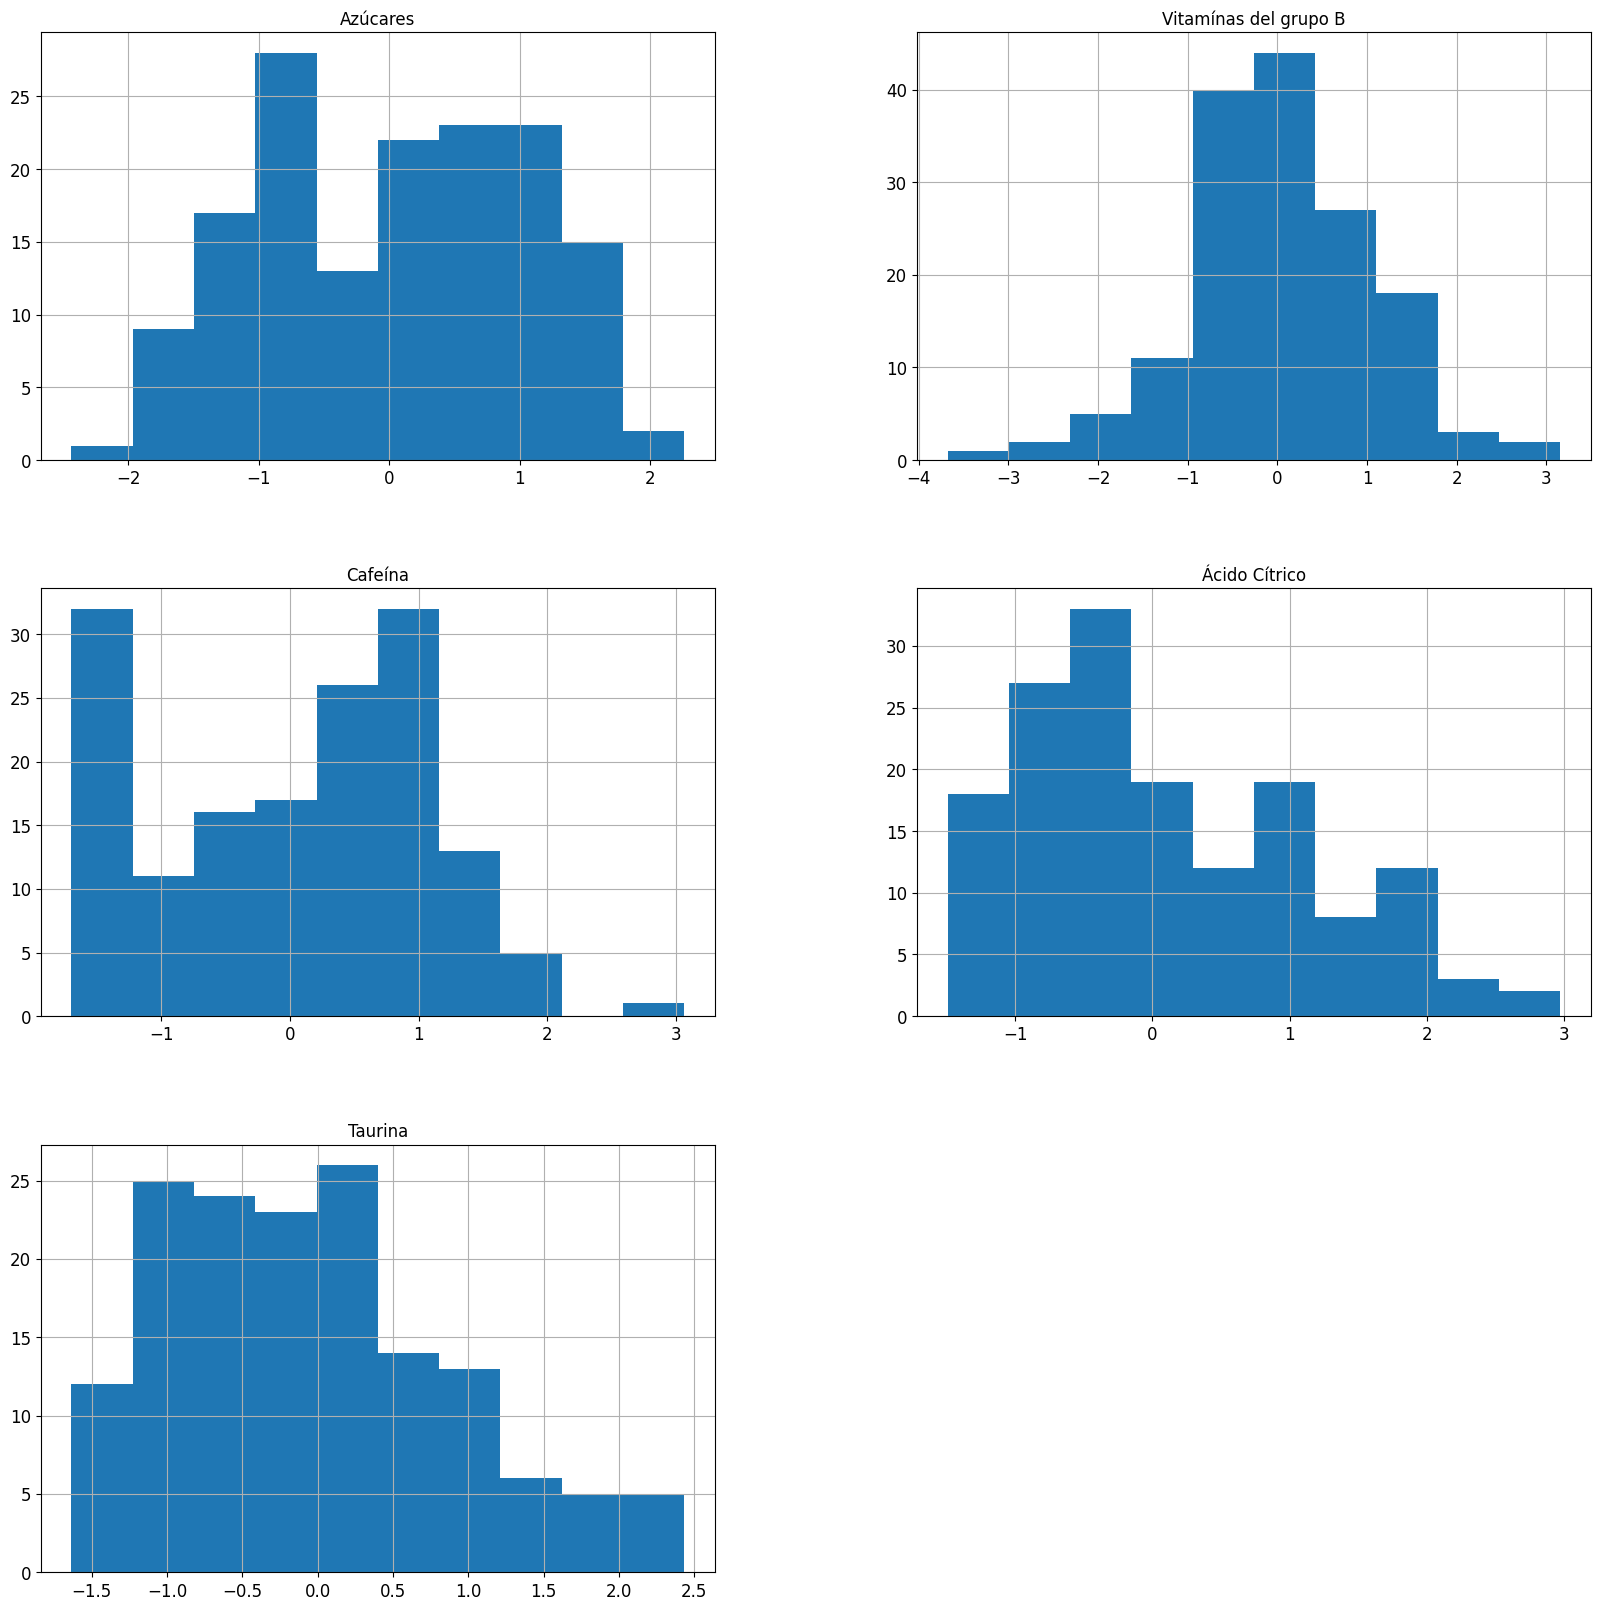

In [259]:
data.hist(figsize=(20,20)); #Le puse el punto y coma para que no me salgan los mensajes del principio.

No tengo variables categóricas.  
Azúcares: Valores bastante dispersos en un rango de -2 a 2. La mayor concentración aparece en -1 con lo cual, y siguiendo el razonamiento anterior, la mayoría de muestras del dataset tienen menos azúcar que la media que estableció el escalador.  
Vitaminas del grupo B: La mayoría se establecen en el entorno de 0 con lo que van a estar en la media, aunque veo más valores en -1 que en 1 lo que hace pensar que en general las bebidas tienden a tener menos vitamina B que la media que interpretó el escalador.  
Cafeína: Curiosamente tenemos un pico en -1 y otro en 1. Podemos interpretar que hay dos tipos de mezclas con niveles de cafeína diferentes pero la trataremos como variable continua claramente.  
Ácido cítrico: La distribución de valores presenta larga cola con la mayor parte de datos entre -0.5 y 0 con lo que las bebidas o tienen el ácido cítrico medio o algo menos.  
Taurina: distribución algo dispersa más bien sesgada a valores menores de 0.5. Muchos negativos presentes.


In [260]:
features_num = ["Azúcares", "Vitamínas del grupo B", "Cafeína", "Ácido Cítrico", "Taurina"] #la lista de features me ayuda después

(5, 2)


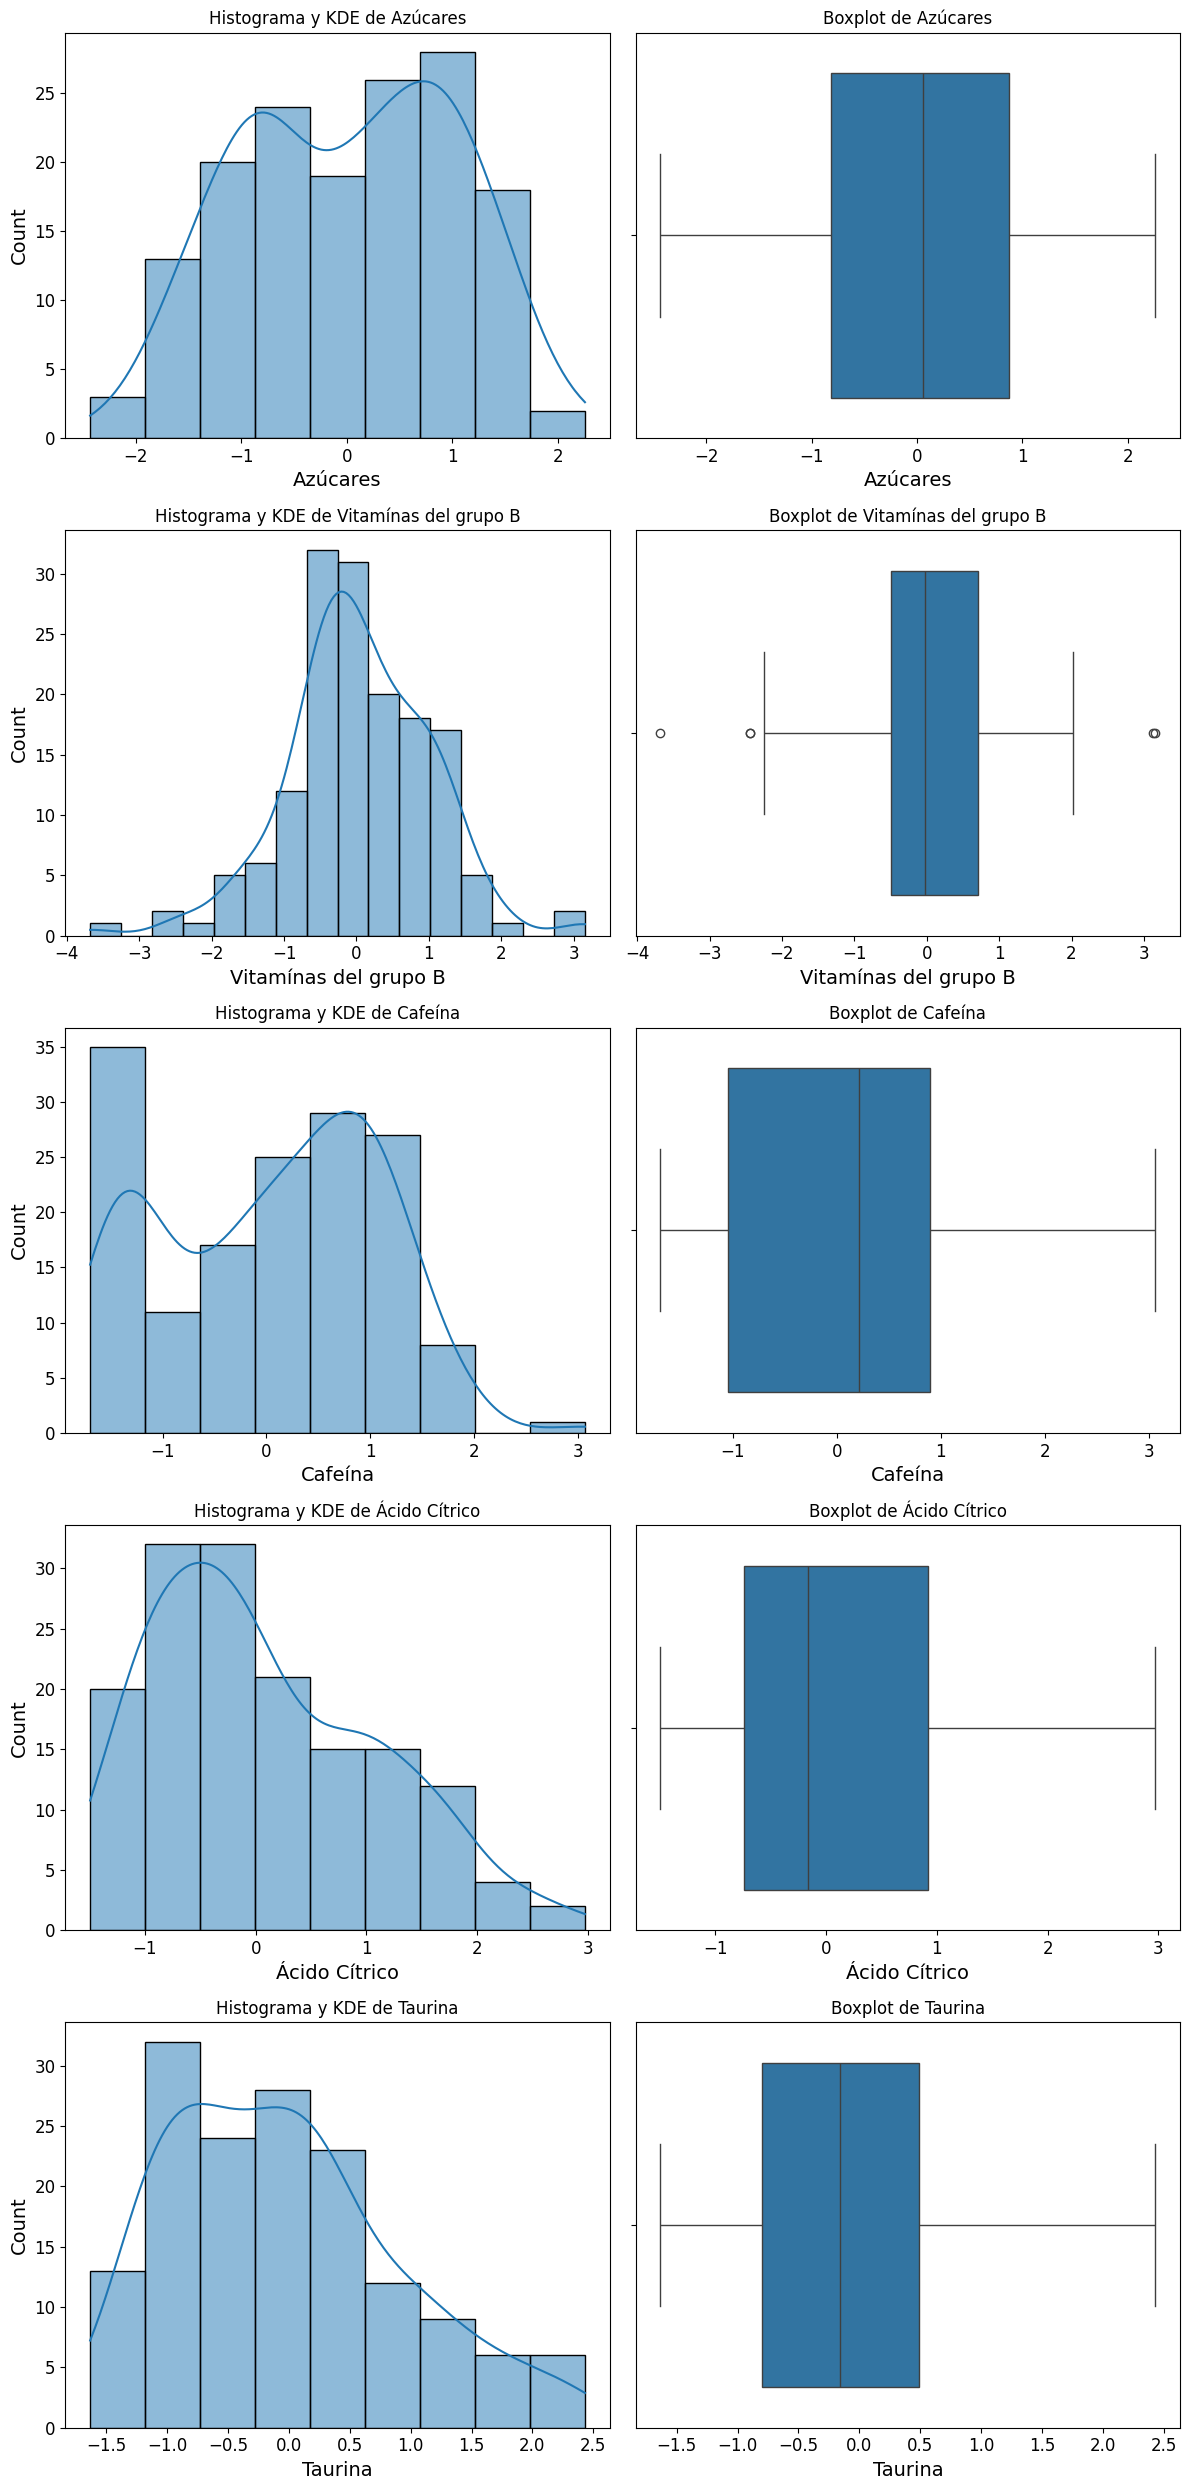

In [261]:
plot_combined_graphs(data, features_num)

No hay outliers más que 2 en vitamina B así que no voy a hacer tratamiento.

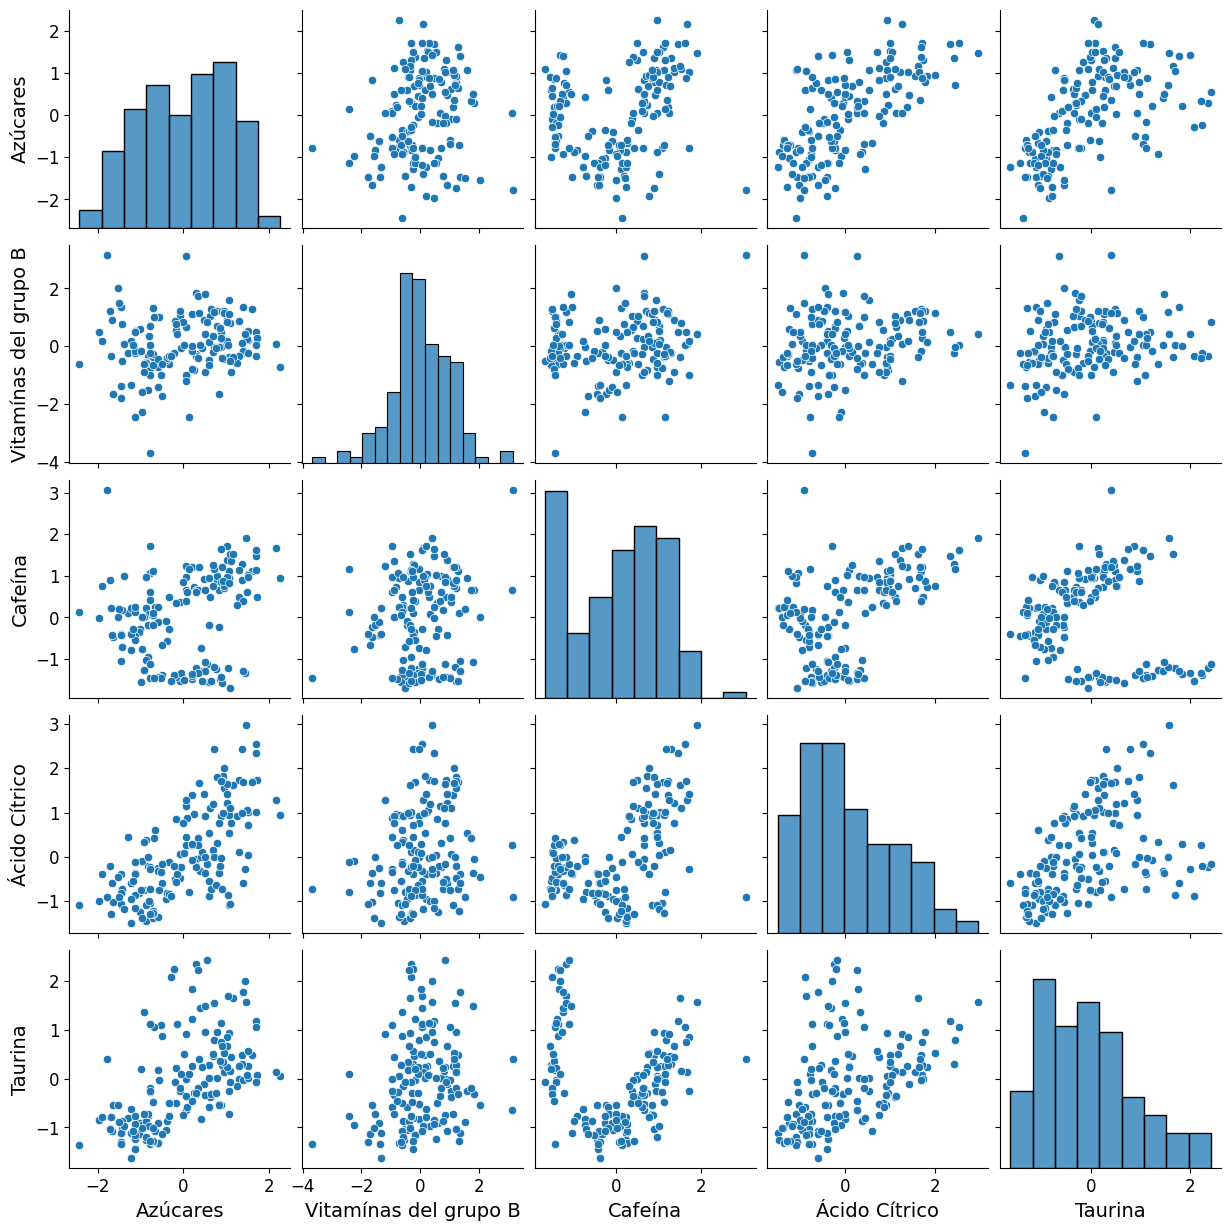

In [262]:
sns.pairplot(data[features_num])

Hagamos el DBSCAN porque así poco se aprecia.

In [263]:
data_copia = data.copy()

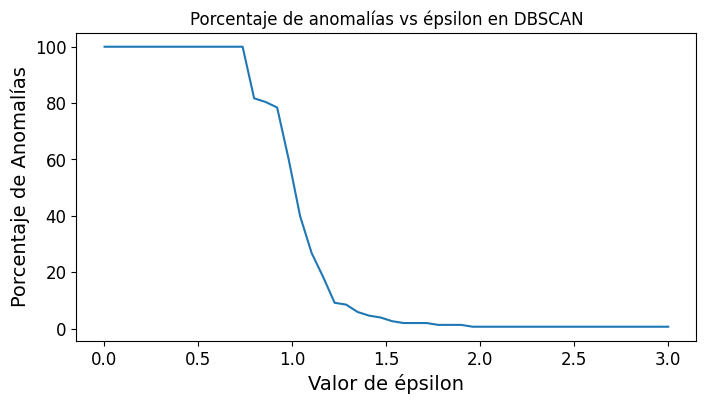

In [264]:
# Lista para almacenar el porcentaje de anomalías
outlier_percent = []

# Número de features seleccionadas
num_features = len(features_num)

# Iteramos sobre un rango de valores de épsilon
for eps in np.linspace(0.001, 3, 50):  # 50 valores entre 0.001 y 3
    # Creamos el modelo DBSCAN con min_samples = 2 * número de features
    dbscan = DBSCAN(eps=eps, min_samples=2 * num_features)
    dbscan.fit(data_copia[features_num])
    
    # Calculamos el porcentaje de puntos etiquetados como anomalías (-1)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    # Guardamos el resultado
    outlier_percent.append(perc_outliers)

# Visualizamos el porcentaje de anomalías en función de épsilon
plt.figure(figsize=(8,4), dpi=100)
sns.lineplot(x=np.linspace(0.001, 3, 50), y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.title("Porcentaje de anomalías vs épsilon en DBSCAN")
plt.show()

A medida que eps aumenta el porcentaje de anomalías disminuye y entre (más o menos) 0.9 y1.3 lo hace muy rápido. A partir de 1.5 estabiliza por debajo del 10%. Con eps< 0.5 tenemos muchas anomalías.

In [265]:
# Estimación tipo "codo" para eps entre 1.5 y 2.2
for indice, eps in [(indice, val) for indice, val in enumerate(np.linspace(0.001, 3, 50)) if 1.5 <= val <= 2.2]:
    print(f"Para eps = {eps:.3f}: {outlier_percent[indice]:.2f}% de anomalías")

Para eps = 1.531: 2.61% de anomalías
Para eps = 1.592: 1.96% de anomalías
Para eps = 1.654: 1.96% de anomalías
Para eps = 1.715: 1.96% de anomalías
Para eps = 1.776: 1.31% de anomalías
Para eps = 1.837: 1.31% de anomalías
Para eps = 1.898: 1.31% de anomalías
Para eps = 1.960: 0.65% de anomalías
Para eps = 2.021: 0.65% de anomalías
Para eps = 2.082: 0.65% de anomalías
Para eps = 2.143: 0.65% de anomalías


A partir de eps=1.96 no hay más reducción de anomalías con lo cual ese es mi mejor eps

In [266]:
#fit DBSCAN with eps = 1.96
#dbscan = DBSCAN(eps=1.96, min_samples= 2*len("features_num"))
dbscan = DBSCAN(eps = 2, min_samples= 2*len("features_num"))
dbscan.fit(data_copia[features_num])

#guardo las etiquetas de cluster en un dataframe
data_copia["Cluster_DBSCAN"]=dbscan.labels_

In [267]:
# Analizo los resultados:
print("Clusters identificados:", np.unique(data_copia["Cluster_DBSCAN"]))
print("Cantidad de puntos por cluster:\n", data_copia["Cluster_DBSCAN"].value_counts())

Clusters identificados: [-1  0]
Cantidad de puntos por cluster:
 Cluster_DBSCAN
 0    151
-1      2
Name: count, dtype: int64


In [268]:
features_num #me lo he copiado para no andar subiendo mucho en el código

['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

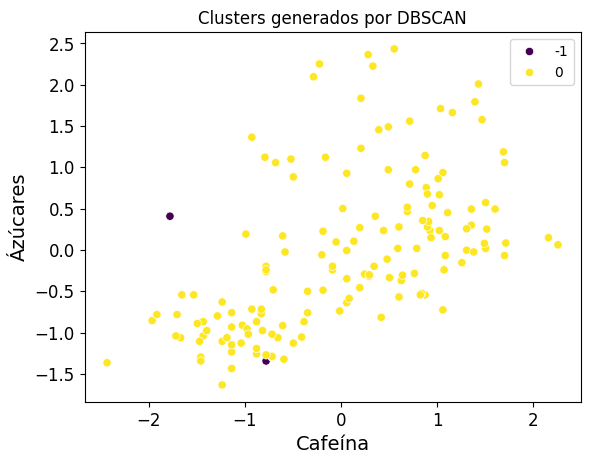

In [269]:
# Visualización de clusters en un par de variables representativas
sns.scatterplot(x=data_copia["Azúcares"], y=data_copia["Taurina"], hue=data_copia["Cluster_DBSCAN"], palette="viridis")
plt.xlabel("Cafeína")
plt.ylabel("Ázúcares")
plt.title("Clusters generados por DBSCAN")
plt.legend()
plt.show()

He probado todas las combinaciones en el código superior, sospecho que tenía que haber tratado las anomalías de las vitaminas. Voy a verlo ahora, a ver si saco un DBSCAN mejor.

In [270]:
data_filtrada = data_copia[(data_copia["Vitamínas del grupo B"] > -3.5) & (data_copia["Vitamínas del grupo B"] < 2.5)].copy()


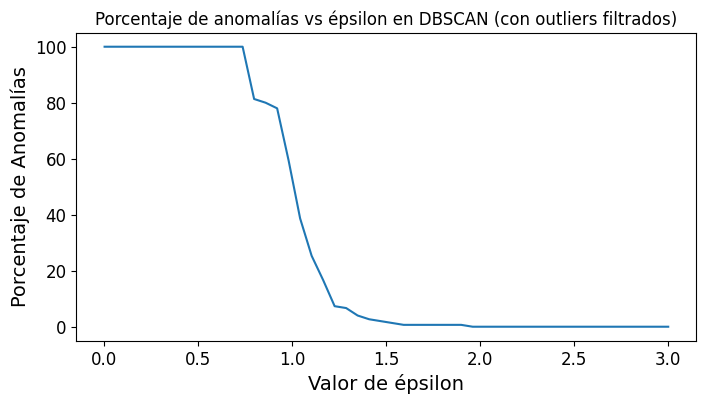

In [271]:
# Lista para almacenar el porcentaje de anomalías
outlier_percent = []

# Número de features seleccionadas
num_features = len(features_num)

# Iteramos sobre un rango de valores de épsilon
for eps in np.linspace(0.001, 3, 50):  # 50 valores entre 0.001 y 3
    # Creamos el modelo DBSCAN con min_samples = 2 * número de features
    dbscan = DBSCAN(eps=eps, min_samples=2 * num_features)
    dbscan.fit(data_filtrada[features_num])  # Aplicamos DBSCAN en datos filtrados
    
    # Calculamos el porcentaje de puntos etiquetados como anomalías (-1)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    # Guardamos el resultado
    outlier_percent.append(perc_outliers)

# Visualizamos el porcentaje de anomalías en función de épsilon
plt.figure(figsize=(8,4), dpi=100)
sns.lineplot(x=np.linspace(0.001, 3, 50), y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.title("Porcentaje de anomalías vs épsilon en DBSCAN (con outliers filtrados)")
plt.show()

In [272]:
# Recalcular la lista de porcentaje de anomalías usando los datos filtrados
outlier_percent_filtrado = []

# Iteramos nuevamente para recalcular valores en data_filtrada
for eps in np.linspace(0.001, 3, 50):  
    dbscan = DBSCAN(eps=eps, min_samples=2 * len(features_num))
    dbscan.fit(data_filtrada[features_num])  # Aplicamos DBSCAN en datos filtrados
    
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    outlier_percent_filtrado.append(perc_outliers)

# Estimación tipo "codo" con datos filtrados para eps entre 1.5 y 2.2
for indice, eps in [(indice, val) for indice, val in enumerate(np.linspace(0.001, 3, 50)) if 1.5 <= val <= 2.2]:
    print(f"Para eps = {eps:.3f}: {outlier_percent_filtrado[indice]:.2f}% de anomalías")

Para eps = 1.531: 1.33% de anomalías
Para eps = 1.592: 0.67% de anomalías
Para eps = 1.654: 0.67% de anomalías
Para eps = 1.715: 0.67% de anomalías
Para eps = 1.776: 0.67% de anomalías
Para eps = 1.837: 0.67% de anomalías
Para eps = 1.898: 0.67% de anomalías
Para eps = 1.960: 0.00% de anomalías
Para eps = 2.021: 0.00% de anomalías
Para eps = 2.082: 0.00% de anomalías
Para eps = 2.143: 0.00% de anomalías


eps = 1.960, lo porbé y obtuve 1 clúster, voy a bajarlo para que me de entre 3 y 5 como dice el enunciado (a ver si lo consigo pero no parece demasiado viable)

In [273]:
#fit DBSCAN with eps = 1.837
#dbscan = DBSCAN(eps=1, min_samples= 2*len("features_num"))
dbscan = DBSCAN(eps = 2, min_samples= 2*len("features_num"))
dbscan.fit(data_filtrada[features_num])

#guardo las etiquetas de cluster en un dataframe
data_filtrada["Cluster_DBSCAN"]=dbscan.labels_

In [274]:
# Analizo los resultados:
print("Clusters identificados:", np.unique(data_filtrada["Cluster_DBSCAN"]))
print("Cantidad de puntos por cluster:\n", data_filtrada["Cluster_DBSCAN"].value_counts())

Clusters identificados: [0]
Cantidad de puntos por cluster:
 Cluster_DBSCAN
0    150
Name: count, dtype: int64


Parece que DBSCAN solo ve una nube de puntos, igual KMeans funciona mejor,vamos a probar.

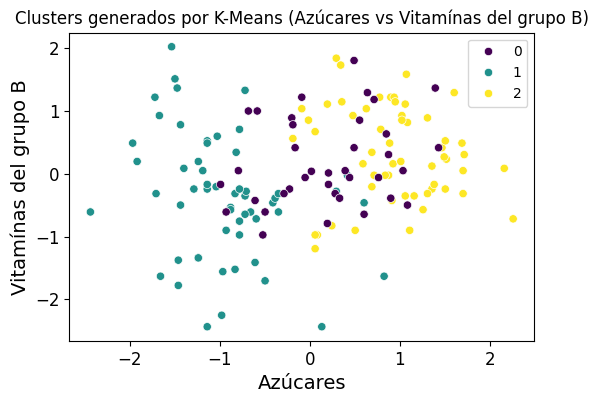

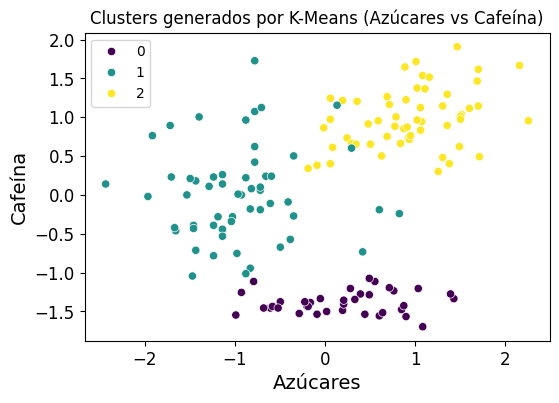

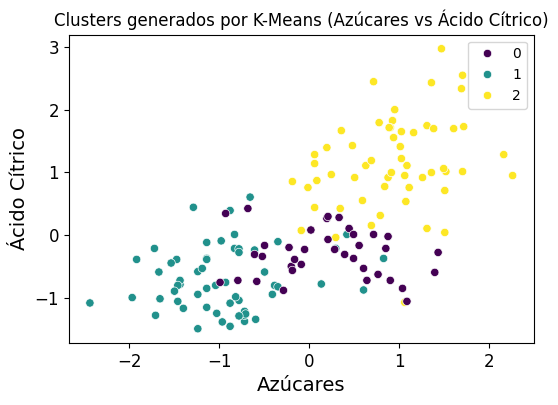

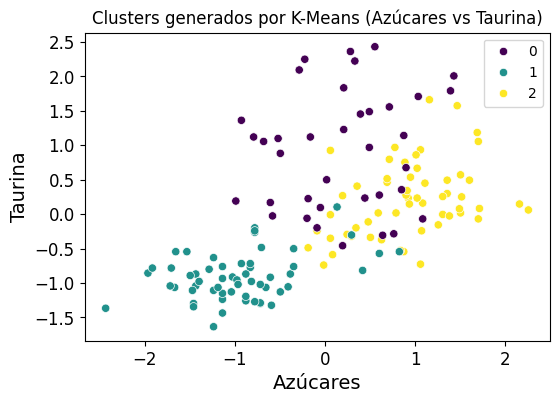

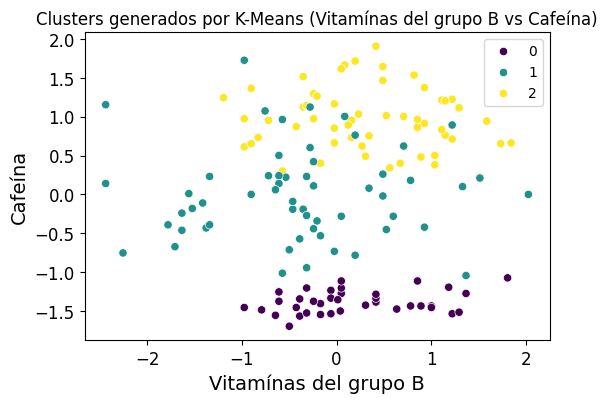

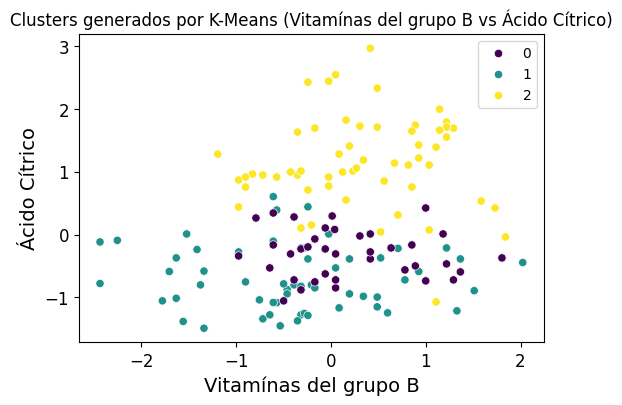

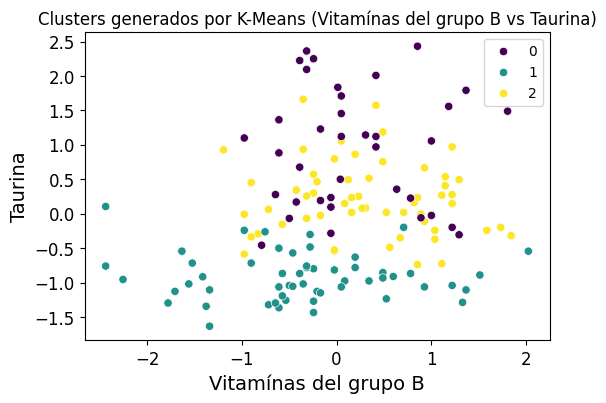

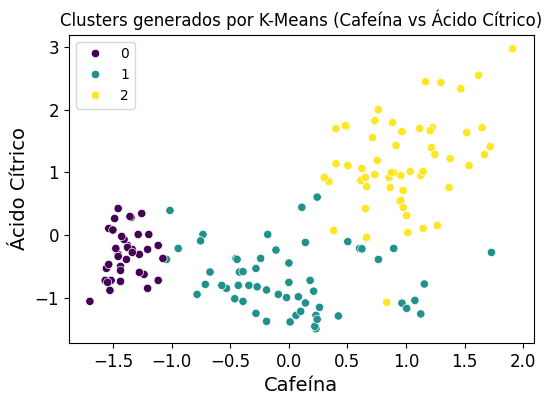

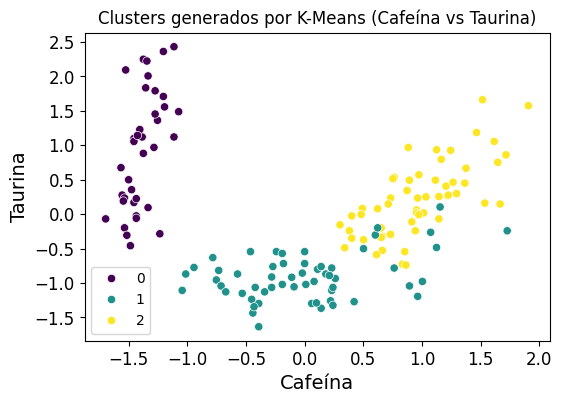

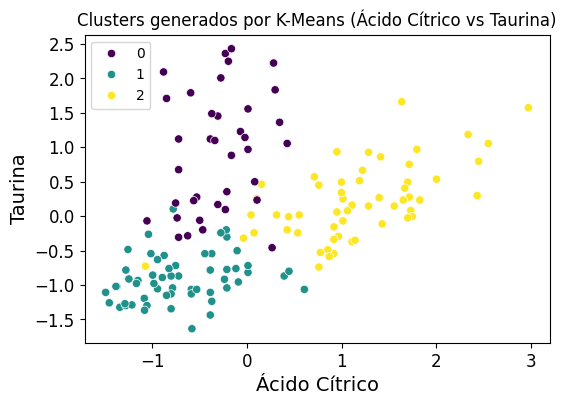

In [275]:
# Definir número de clusters
num_clusters = 3  

# Iterar sobre todas las combinaciones de pares de features
for feature_x, feature_y in itertools.combinations(features_num, 2): #esto genera todas las posibles combinaciones de pares de features_num. Le pasas la lista de features y 2 para que sean pares de datos
    # Aplicar K-Means
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    data_filtrada["Cluster_KMeans"] = kmeans.fit_predict(data_filtrada[features_num]) #guardo las predicciones de número de cluster en una columna del dataset y fit_predict es como hacer primero el fit y luego el predict pero todo junto.

    # Crear scatter plot para la combinación actual
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=data_filtrada[feature_x], y=data_filtrada[feature_y], hue=data_filtrada["Cluster_KMeans"], palette="viridis")
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.title(f"Clusters generados por K-Means ({feature_x} vs {feature_y})")
    plt.legend()
    plt.show()

Probé 3,4 y 5. Me gusta más 3 pero tampoco me parece una maravilla. Al final, yo lo que veo es una nube de puntos más o menos separados pero una nube. Pero como negocio lo pide así, así lo haremos.

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [276]:
# Cargar los nuevos experimentos
new_experiments = pd.read_csv("./data/new_experiments.csv", sep="|")

new_experiments

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583
5,0.962743,-0.243142,-1.354622,-0.420013,1.956043


In [277]:
# Aplicar el modelo K-Means entrenado
new_experiments["Cluster_KMeans"] = kmeans.predict(new_experiments)

# Mostrar los resultados
print(new_experiments)

# Guardar los resultados
new_experiments.to_csv("./data/results_new_experiments.csv", index=False)


   Azúcares  Vitamínas del grupo B   Cafeína  Ácido Cítrico   Taurina  \
0  1.481555               0.305159  1.366128       2.239039  0.731870   
1  0.616869               0.890014  0.583034       0.312420 -0.665332   
2 -1.680724               0.341713 -0.340615      -0.213021 -0.976782   
3 -0.284874              -1.412851 -0.782361      -1.193845 -0.717240   
4 -0.927212               0.634140 -1.565455      -0.085641 -0.522583   
5  0.962743              -0.243142 -1.354622      -0.420013  1.956043   

   Cluster_KMeans  
0               2  
1               2  
2               1  
3               1  
4               0  
5               0  


Parece que ha funcionado medianamente bien, al menos ha asignado 3 clusters.

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.

In [278]:
# Cargar datasets nuevamente
empowering_drinks = pd.read_csv("./data/empowering_drinks.csv", sep="|")
power_results = pd.read_csv("./data/power_results.csv", sep="|")

# Fusionar si tienen un identificador común (ID, experiment_number, etc.). Por lo que veo en los datasets "Energization_Level" y "class" es lo mismo
if "ID" in empowering_drinks.columns and "ID" in power_results.columns:
    empowering_drinks = empowering_drinks.merge(power_results, on="ID", how="left")
else:
    empowering_drinks["Energization_Level"] = power_results["class"]  # Fusionar manualmente si tienen el mismo orden (he visto en el dataset que el número de filas no cuadran pero las comunes tienen todas el mismo valor)

# Verificar que la columna esté restaurada
print(empowering_drinks.columns)

Index(['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico',
       'Taurina', 'Energization_Level'],
      dtype='object')


In [279]:
empowering_drinks

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina,Energization_Level
0,1.518613,0.232053,1.034819,1.013009,0.251717,1
1,0.246290,-0.827996,0.733629,0.965242,-0.293321,1
2,0.196879,1.109334,1.215533,1.395148,0.269020,1
3,1.691550,0.487926,1.466525,2.334574,1.186068,1
4,0.295700,1.840403,0.663351,-0.037874,-0.319276,1
...,...,...,...,...,...,...
148,0.493343,0.414820,-1.284344,0.009893,0.969783,3
149,0.332758,-0.389355,-1.344582,0.280575,2.224236,3
150,0.209232,0.012732,-1.354622,0.296498,1.834923,3
151,1.395086,1.365208,-1.274305,-0.595160,1.791666,3


In [280]:
kmeans = KMeans(n_clusters=3, random_state=42)
empowering_drinks["Cluster_KMeans"] = kmeans.fit_predict(empowering_drinks[features_num])

In [281]:
# Verificar que la columna esté presente
print(empowering_drinks.columns)

# Comparar los clusters de K-Means con los niveles reales de energización
print(pd.crosstab(empowering_drinks["Cluster_KMeans"], empowering_drinks["Energization_Level"]))

# Calcular el Adjusted Rand Index (ARI) para medir la similitud entre la segmentación del modelo y la clasificación real
ari_score = adjusted_rand_score(empowering_drinks["Cluster_KMeans"], empowering_drinks["Energization_Level"])
print(f"Adjusted Rand Index (ARI): {ari_score:.3f}")

# Mostrar la matriz de confusión
print("Matriz de confusión:")
print(confusion_matrix(empowering_drinks["Energization_Level"], empowering_drinks["Cluster_KMeans"]))

Index(['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico',
       'Taurina', 'Energization_Level', 'Cluster_KMeans'],
      dtype='object')
Energization_Level   1   2   3
Cluster_KMeans                
0                    1  57   0
1                    0   0  37
2                   55   3   0
Adjusted Rand Index (ARI): 0.914
Matriz de confusión:
[[ 0  0  0  0]
 [ 1  0 55  0]
 [57  0  3  0]
 [ 0 37  0  0]]


Cluster 0, nivel 2: 57 bebidas  
Cluster 1, nivel 3: 37 bebidas  
Cluster 2, nivel 1: 55 bebidas  

ARI cercano a 1 indica buena segmentación así que, en principio, parece que está bien segmentado.
